<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Algoritmos genéticos

### Integrantes del grupo:
- David Guarín Castro - davidg@marketpsychdata.com
- Federico Otero - fede.e.otero@gmail.com

In [113]:
# Importo las librerías
import matplotlib.pyplot as plt
import numpy as np
import math

### Ejercicio 1

Una fábrica produce cuatro tipos de partes automotrices. Cada una de ellas primero se fabrica y luego se le dan los acabados. Las horas de trabajador requeridas y la utilidad para cada parte son las siguientes:

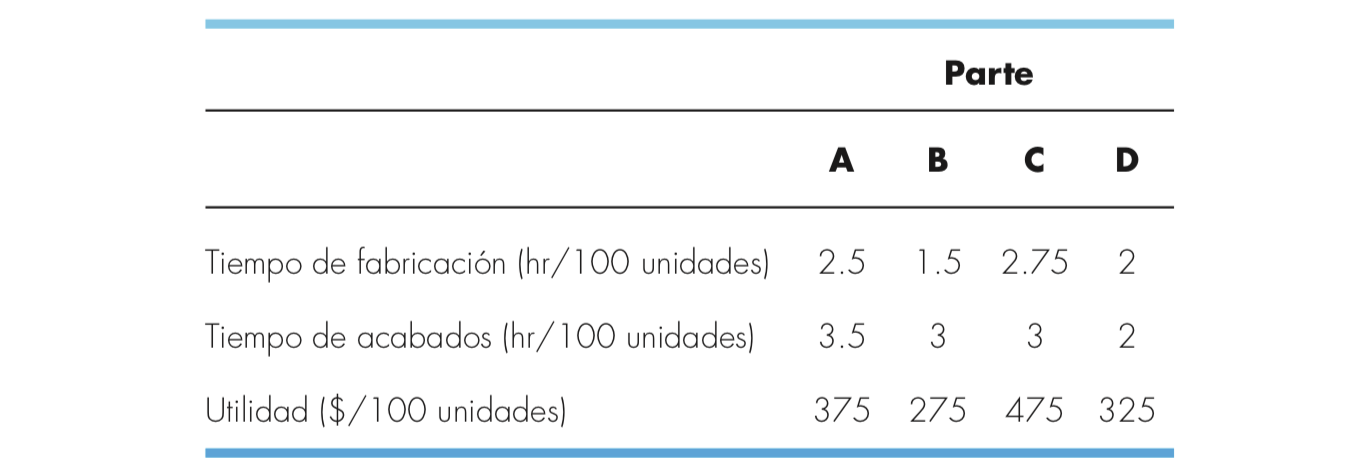

Las capacidades de los talleres de fabricación y acabados para el mes siguiente son de 640 y 960 horas, respectivamente. Determinar mediante un algoritmo PSO con restricciones (sin usar bibliotecas para PSO) que cantidad de cada partes debe producirse a fin de maximizar la utilidad y resolver las siguientes consignas:

Modelamos este problema de la siguiente manera:

Queremos **maximizar** la utilidad:

**U = 375 * x1 + 275 * x2 + 475 * x3 + 325 * x4**

Sujeto a:

**2.5 * x1 + 1.5 * x2 + 2.75 * x3 + 2 * x4 <= 640**

**3.5 * x1 + 3 * x2 + 3 * x3 + 2 * x4 <= 960**

**a. (Valor 0.33 puntos) Transcribir el algoritmo escrito en Python a un archivo .pdf de acuerdo a los siguientes parámetros: número de partículas = 20, máximo número de iteraciones 50, coeficientes de aceleración c1 = c2 = 1.4944, factor de inercia w = 0.6.**

**b. (Valor 0.33 puntos) Transcribir al .pdf la solución óptima encontrada (dominio) y el valor objetivo óptimo (imagen).**

**c. (Valor 0.33 puntos) Indicar en el .pdf la URL del repositorio en donde se encuentra el algoritmo PSO.**

**d. (Valor 0.5 puntos) Realizar un gráfico de línea que muestre gbest (eje de ordenadas) en función de las iteraciones realizadas (eje de abscisas). El gráfico debe contener etiquetas en los ejes, leyenda y un título. El gráfico debe ser pegado en el .pdf.**

**e. (Valor 0.5 puntos) Explicar (en el .pdf) y demostrar (desde el código fuente) que sucede si se reduce en 1 unidad el tiempo de acabado de la parte B.**

**f. (Valor 1 punto) Realizar 3 boxplots a partir de los gbest de 3 variantes de solución: i) El primer boxplot con el coeficiente de inercia constante w = 0.8, ii) El segundo boxplot con el coeficiente de inercia dinámico lineal y iii) El tercer boxplot sin coeficiente de inercia pero aplicando Factor de constricción con φ a elección.**

**g. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de los resultados del ítem (f).**

**h. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de qué cantidad mínima de partículas es factible utilizar para este problema específicamente.**

Los puntos **b**, **c**, **g** y **h** figuran en el informe.

In [54]:
# Función objetivo a maximizar
def f(x):
    return 375 * x[0] + 275 * x[1] + 475 * x[2] + 325 * x[3]  # U = 375 * x1 + 275 * x2 + 475 * x3 + 325 * x4


# Primera restriccion: Tiempo de fabricación
def g1(x):
    return 2.5 * x[0] + 1.5 * x[1] + 2.75 * x[2] + 2 * x[3]  <= 640  # restriccion: 2.5 * x1 + 1.5 * x2 + 2.75 * x3 + 2 * x4 <= 640


# Segunda restriccion: Tiempo de acabado
def g2(x):
    return 3.5 * x[0] + 3 * x[1] + 3 * x[2] + 2 * x[3] <= 960  # restriccion: 3.5 * x1 + 3 * x2 + 3 * x3 + 2 * x4 <= 960

# parametros
n_particles = 20 
n_dimensions = 4
max_iterations = 50
c1 = c2 = 1.4944
w = 0.6

In [67]:
# Inicialización de particulas
x = np.zeros((n_particles, n_dimensions))
v = np.zeros((n_particles, n_dimensions))
pbest = np.zeros((n_particles, n_dimensions))
pbest_fit = -np.inf * np.ones(n_particles)
gbest = np.zeros(n_dimensions)
gbest_fit = -np.inf

In [68]:
# Inicializamos partículas factibles
for i in range(n_particles):
    while True:
        x[i] = np.random.uniform(0, 100, n_dimensions)
        if g1(x[i]) and g2(x[i]): 
            break
    v[i] = np.random.uniform(-1, 1, n_dimensions)
    pbest[i] = x[i].copy()
    fit = f(x[i])
    if fit > pbest_fit[i]:
        pbest_fit[i] = fit

In [71]:
# Optimizacion
gbest_fit_iterations = []
for _ in range(max_iterations):
    for i in range(n_particles):
        fit = f(x[i])
        # Se comprueba si la nueva aptitud es mejor y si cumple las restricciones
        if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
            pbest_fit[i] = fit
            pbest[i] = x[i].copy()
            if fit > gbest_fit:
                gbest_fit = fit
                gbest = x[i].copy()

        # Actualizacion de la velocidad y la posicion de la particula
        v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])
        x[i] += v[i]

        if not (g1(x[i]) and g2(x[i])):
            x[i] = pbest[i].copy()
    gbest_fit_iterations.append(gbest_fit)

# Se imprime la mejor solucion encontrada y también su valor optimo
print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f}, {gbest[2]:.4f}, {gbest[3]:.4f}]")
print(f"Valor optimo: {gbest_fit}")


particula: [77.65097617 16.29120593 28.08766056 83.08065004], fit: 73942.0477245143
No actualizo partícula porque salió de su límite
particula: [ 4.45952434 67.89616612 72.85433577 38.99729076], fit: 67623.69629333742
No actualizo partícula porque salió de su límite
particula: [63.02947178 15.1241313  92.11732376 22.05381303], fit: 78718.40604820338
No actualizo partícula porque salió de su límite
particula: [37.40385518 44.12292844 31.29614664 37.24947695], fit: 53132.00067190097
No actualizo partícula porque salió de su límite
particula: [35.44707601 18.87204396 83.24006239 64.72732266], fit: 79057.87509376163
No actualizo partícula porque salió de su límite
particula: [55.33590423  2.68770084 71.55068771 87.86081734], fit: 84031.42411792149
No actualizo partícula porque salió de su límite
particula: [13.10479677 17.16748346 29.90558125 96.67111784], fit: 55258.62113319852
No actualizo partícula porque salió de su límite
particula: [23.92700369 66.72542143  3.07405398 90.37198488], f

**d. (Valor 0.5 puntos) Realizar un gráfico de línea que muestre gbest (eje de ordenadas) en función de las iteraciones realizadas (eje de abscisas). El gráfico debe contener etiquetas en los ejes, leyenda y un título. El gráfico debe ser pegado en el .pdf.**


In [87]:
gbest_fit_iterations_to_graph = [0 if e == -np.inf else e for e in gbest_fit_iterations]

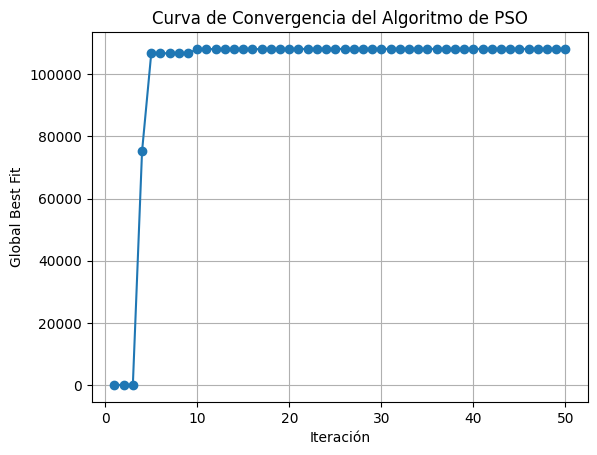

In [88]:
#valores_originales = np.array(comparacion_resultados['ruleta'])[:, 1]
plt.plot(range(1, max_iterations + 1), gbest_fit_iterations_to_graph, marker='o')
plt.xlabel('Iteración')
plt.ylabel('Global Best Fit')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.grid(True)
plt.show()

**e. (Valor 0.5 puntos) Explicar (en el .pdf) y demostrar (desde el código fuente) que sucede si se reduce en 1 unidad el tiempo de acabado de la parte B.**

In [90]:
# Actualizamos la segunda restriccion: Tiempo de acabado
def g2(x):
    return 3.5 * x[0] + 2 * x[1] + 3 * x[2] + 2 * x[3] <= 960  # restriccion: 3.5 * x1 + 2 * x2 + 3 * x3 + 2 * x4 <= 960


In [91]:
# Inicialización de particulas
x = np.zeros((n_particles, n_dimensions))
v = np.zeros((n_particles, n_dimensions))
pbest = np.zeros((n_particles, n_dimensions))
pbest_fit = -np.inf * np.ones(n_particles)
gbest = np.zeros(n_dimensions)
gbest_fit = -np.inf

In [92]:
# Inicializamos partículas factibles
for i in range(n_particles):
    while True:
        x[i] = np.random.uniform(0, 100, n_dimensions)
        if g1(x[i]) and g2(x[i]): 
            break
    v[i] = np.random.uniform(-1, 1, n_dimensions)
    pbest[i] = x[i].copy()
    fit = f(x[i])
    if fit > pbest_fit[i]:
        pbest_fit[i] = fit

In [93]:
# Optimizacion
gbest_fit_iterations_mod = []
for _ in range(max_iterations):
    for i in range(n_particles):
        fit = f(x[i])
        # Se comprueba si la nueva aptitud es mejor y si cumple las restricciones
        if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
            pbest_fit[i] = fit
            pbest[i] = x[i].copy()
            if fit > gbest_fit:
                gbest_fit = fit
                gbest = x[i].copy()

        # Actualizacion de la velocidad y la posicion de la particula
        v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])
        x[i] += v[i]

        if not (g1(x[i]) and g2(x[i])):
            x[i] = pbest[i].copy()
    gbest_fit_iterations_mod.append(gbest_fit)

# Se imprime la mejor solucion encontrada y también su valor optimo
print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f}, {gbest[2]:.4f}, {gbest[3]:.4f}]")
print(f"Valor optimo: {gbest_fit}")


Mejor solucion: [-3.5167, 14.9267, 249.0431, -29.2334]
Valor optimo: 111580.6915472145


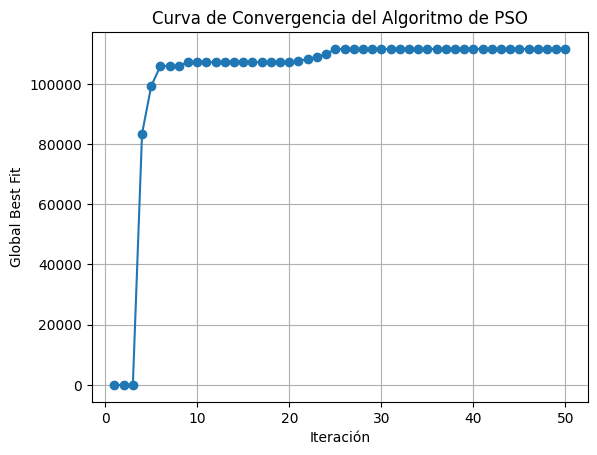

In [95]:
gbest_fit_iterations_mod_to_graph = [0 if e == -np.inf else e for e in gbest_fit_iterations_mod]
plt.plot(range(1, max_iterations + 1), gbest_fit_iterations_mod_to_graph, marker='o')
plt.xlabel('Iteración')
plt.ylabel('Global Best Fit')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.grid(True)
plt.show()

**f. (Valor 1 punto) Realizar 3 boxplots a partir de los gbest de 3 variantes de solución: i) El primer boxplot con el coeficiente de inercia constante w = 0.8, ii) El segundo boxplot con el coeficiente de inercia dinámico lineal y iii) El tercer boxplot sin coeficiente de inercia pero aplicando Factor de constricción con φ a elección.**

**Variante (i): w = 0.8**

In [97]:
# Función objetivo a maximizar
def f(x):
    return 375 * x[0] + 275 * x[1] + 475 * x[2] + 325 * x[3]  # U = 375 * x1 + 275 * x2 + 475 * x3 + 325 * x4


# Primera restriccion: Tiempo de fabricación
def g1(x):
    return 2.5 * x[0] + 1.5 * x[1] + 2.75 * x[2] + 2 * x[3]  <= 640  # restriccion: 2.5 * x1 + 1.5 * x2 + 2.75 * x3 + 2 * x4 <= 640


# Segunda restriccion: Tiempo de acabado
def g2(x):
    return 3.5 * x[0] + 3 * x[1] + 3 * x[2] + 2 * x[3] <= 960  # restriccion: 3.5 * x1 + 3 * x2 + 3 * x3 + 2 * x4 <= 960

# parametros
n_particles = 20 
n_dimensions = 4
max_iterations = 50
c1 = c2 = 1.4944
w = 0.8

In [98]:
# Inicialización de particulas
x = np.zeros((n_particles, n_dimensions))
v = np.zeros((n_particles, n_dimensions))
pbest = np.zeros((n_particles, n_dimensions))
pbest_fit = -np.inf * np.ones(n_particles)
gbest = np.zeros(n_dimensions)
gbest_fit = -np.inf

In [99]:
# Inicializamos partículas factibles
for i in range(n_particles):
    while True:
        x[i] = np.random.uniform(0, 100, n_dimensions)
        if g1(x[i]) and g2(x[i]): 
            break
    v[i] = np.random.uniform(-1, 1, n_dimensions)
    pbest[i] = x[i].copy()
    fit = f(x[i])
    if fit > pbest_fit[i]:
        pbest_fit[i] = fit

In [100]:
# Optimizacion
gbest_fit_iterations_box_i = []
for _ in range(max_iterations):
    for i in range(n_particles):
        fit = f(x[i])
        # Se comprueba si la nueva aptitud es mejor y si cumple las restricciones
        if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
            pbest_fit[i] = fit
            pbest[i] = x[i].copy()
            if fit > gbest_fit:
                gbest_fit = fit
                gbest = x[i].copy()

        # Actualizacion de la velocidad y la posicion de la particula
        v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])
        x[i] += v[i]

        if not (g1(x[i]) and g2(x[i])):
            x[i] = pbest[i].copy()
    gbest_fit_iterations_box_i.append(gbest_fit)

# Se imprime la mejor solucion encontrada y también su valor optimo
print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f}, {gbest[2]:.4f}, {gbest[3]:.4f}]")
print(f"Valor optimo: {gbest_fit}")


Mejor solucion: [-127.5922, 252.8185, 127.1878, 114.9926]
Valor optimo: 119464.80929365815


**Variante (ii): w --> Coeficiente de inercia dinámico lineal**

In [106]:
w_min = 0.4
w_max = 0.9

In [107]:
# Inicialización de particulas
x = np.zeros((n_particles, n_dimensions))
v = np.zeros((n_particles, n_dimensions))
pbest = np.zeros((n_particles, n_dimensions))
pbest_fit = -np.inf * np.ones(n_particles)
gbest = np.zeros(n_dimensions)
gbest_fit = -np.inf

In [108]:
# Inicializamos partículas factibles
for i in range(n_particles):
    while True:
        x[i] = np.random.uniform(0, 100, n_dimensions)
        if g1(x[i]) and g2(x[i]): 
            break
    v[i] = np.random.uniform(-1, 1, n_dimensions)
    pbest[i] = x[i].copy()
    fit = f(x[i])
    if fit > pbest_fit[i]:
        pbest_fit[i] = fit

In [109]:
# Optimizacion
gbest_fit_iterations_box_ii = []
for it in range(max_iterations):
    for i in range(n_particles):
        fit = f(x[i])
        # Se comprueba si la nueva aptitud es mejor y si cumple las restricciones
        if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
            pbest_fit[i] = fit
            pbest[i] = x[i].copy()
            if fit > gbest_fit:
                gbest_fit = fit
                gbest = x[i].copy()

        # Actualizacion de la inercia, la velocidad y la posicion de la particula
        w = w_max - ((w_max - w_min)/ max_iterations) * it
        v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])
        x[i] += v[i]

        if not (g1(x[i]) and g2(x[i])):
            x[i] = pbest[i].copy()
    gbest_fit_iterations_box_ii.append(gbest_fit)

# Se imprime la mejor solucion encontrada y también su valor optimo
print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f}, {gbest[2]:.4f}, {gbest[3]:.4f}]")
print(f"Valor optimo: {gbest_fit}")


Mejor solucion: [61.6891, 113.2657, 68.8192, 63.3130]
Valor optimo: 107547.3097249519


**Variante (iii): Sin coeficiente de inercia pero con factor de constricción**

In [118]:
c1 = c2 = 2.02
phi = c1 + c2
cons_factor = 2 / abs(2 - phi - (math.sqrt(phi ** 2 - 4 * phi)))

In [127]:
# Inicialización de particulas
x = np.zeros((n_particles, n_dimensions))
v = np.zeros((n_particles, n_dimensions))
pbest = np.zeros((n_particles, n_dimensions))
pbest_fit = -np.inf * np.ones(n_particles)
gbest = np.zeros(n_dimensions)
gbest_fit = -np.inf

In [128]:
# Inicializamos partículas factibles
for i in range(n_particles):
    while True:
        x[i] = np.random.uniform(0, 100, n_dimensions)
        if g1(x[i]) and g2(x[i]): 
            break
    v[i] = np.random.uniform(-1, 1, n_dimensions)
    pbest[i] = x[i].copy()
    fit = f(x[i])
    if fit > pbest_fit[i]:
        pbest_fit[i] = fit

In [129]:
# Optimizacion
gbest_fit_iterations_box_iii = []
for it in range(max_iterations):
    for i in range(n_particles):
        fit = f(x[i])
        # Se comprueba si la nueva aptitud es mejor y si cumple las restricciones
        if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
            pbest_fit[i] = fit
            pbest[i] = x[i].copy()
            if fit > gbest_fit:
                gbest_fit = fit
                gbest = x[i].copy()

        # Actualizacion de la velocidad y la posicion de la particula
        v[i] = cons_factor * (v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) +  c2 * np.random.rand() * (gbest - x[i]) )
        #v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])
        x[i] += v[i]

        if not (g1(x[i]) and g2(x[i])):
            x[i] = pbest[i].copy()
    gbest_fit_iterations_box_iii.append(gbest_fit)

# Se imprime la mejor solucion encontrada y también su valor optimo
print(f"Mejor solucion: [{gbest[0]:.4f}, {gbest[1]:.4f}, {gbest[2]:.4f}, {gbest[3]:.4f}]")
print(f"Valor optimo: {gbest_fit}")


Mejor solucion: [80.7409, 41.7121, 94.2207, 58.2362]
Valor optimo: 105430.24766335072


In [131]:
gbest_fit_iterations_box_i_graph = [0 if e == -np.inf else e for e in gbest_fit_iterations_box_i]
gbest_fit_iterations_box_ii_graph = [0 if e == -np.inf else e for e in gbest_fit_iterations_box_ii]
gbest_fit_iterations_box_iii_graph = [0 if e == -np.inf else e for e in gbest_fit_iterations_box_iii]

In [138]:
matrix_gbest_fit = np.column_stack((gbest_fit_iterations_box_i_graph, gbest_fit_iterations_box_ii_graph, gbest_fit_iterations_box_iii_graph))

In [141]:
boxplot_labels = ['w=0.8', 'w dinámico lineal', 'f de constriccion']

Text(0.5, 1.0, 'Comparación de Inercias')

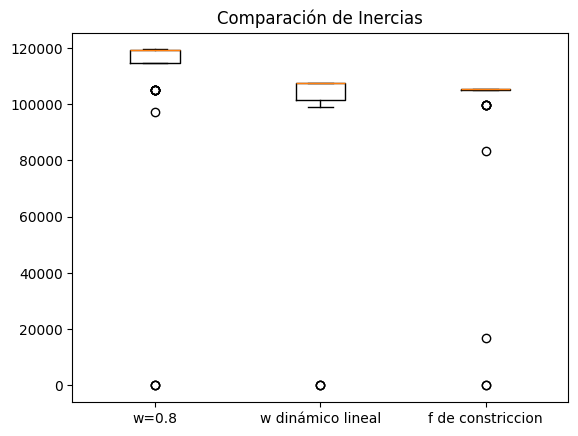

In [142]:
plt.boxplot(matrix_gbest_fit, tick_labels=boxplot_labels)
plt.title('Comparación de Inercias')